Coefficients: [-0.5424748943607989,0.7804116602119681,0.761960863252822,1.7706411201418168e-10]
Intercept: -0.012718902981933303
Root Mean Squared Error (RMSE) na trening setu = 0.707585
Coefficients Adjusted: [-0.018211173960902778,1.3983186895514594,-0.6700825052179387,-1.2016840262324182e-06,6.192597794940481,614.6393497408753]
Intercept Adjusted: -616.0028370763023
Root Mean Squared Error (RMSE) na trening setu Adjusted = 44.7631


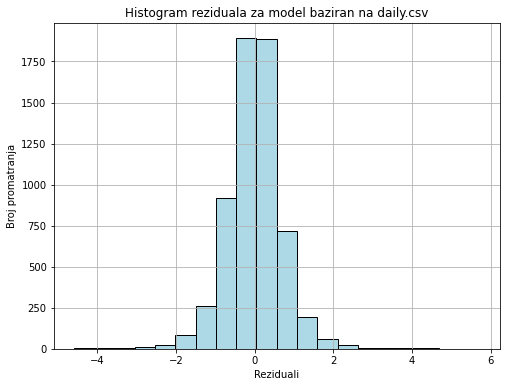

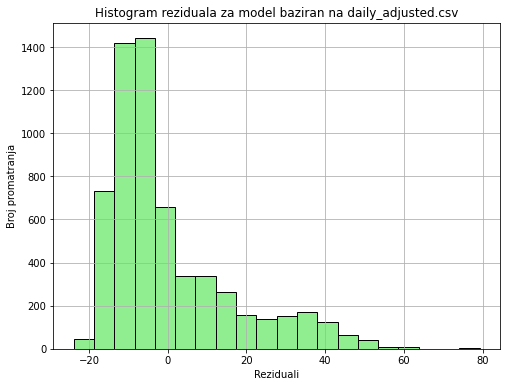

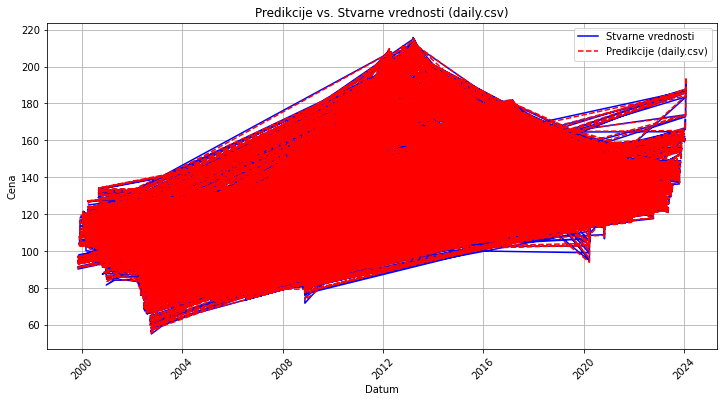

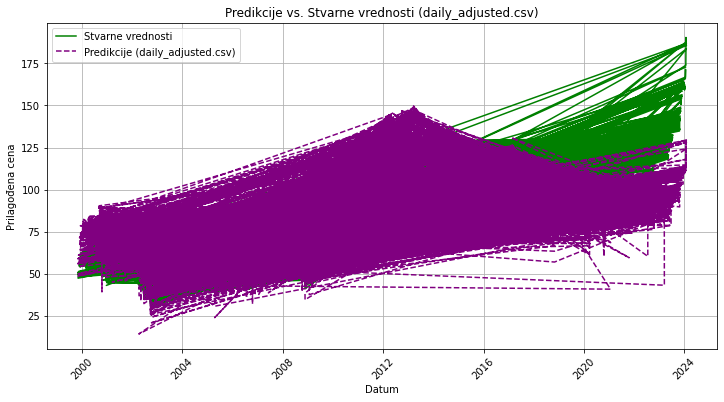

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

# Inicijalizacija Spark sesije
spark = SparkSession.builder \
    .appName("Stock Price Prediction") \
    .getOrCreate()

# Putanje do CSV fajlova
daily_csv_path = "dbfs:/FileStore/daily-1.csv"
daily_adjusted_csv_path = "dbfs:/FileStore/daily_adjusted-1.csv"

# Učitavanje podataka iz CSV fajlova u DataFrame i keširanje
daily_df = spark.read.option("header", "true").option("inferSchema", "true").csv(daily_csv_path).cache()
daily_adjusted_df = spark.read.option("header", "true").option("inferSchema", "true").csv(daily_adjusted_csv_path).cache()

# Analiza korišćenjem daily.csv
# Primer analize: Linear Regression za predikciju cene na osnovu otvaranja, visine, niske i obima trgovanja
assembler = VectorAssembler(inputCols=["open", "high", "low", "volume"], outputCol="features")
daily_df = assembler.transform(daily_df)

lr = LinearRegression(featuresCol="features", labelCol="close")
lr_model = lr.fit(daily_df)

# Prikaz koeficijenata modela
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

# Procena performansi modela
predictions = lr_model.transform(daily_df)
evaluator = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) na trening setu = %g" % rmse)

# Analiza korišćenjem daily_adjusted.csv
# Primer analize: Linear Regression za predikciju prilagođene cene na osnovu otvaranja, visine, niske, obima trgovanja, iznosa dividende i koeficijenta podele
assembler_adj = VectorAssembler(inputCols=["open", "high", "low", "volume", "dividendAmount", "splitCoefficient"], outputCol="features")
daily_adjusted_df = assembler_adj.transform(daily_adjusted_df)

lr_adj = LinearRegression(featuresCol="features", labelCol="adjustedClose")
lr_adj_model = lr_adj.fit(daily_adjusted_df)

# Prikaz koeficijenata modela
print("Coefficients Adjusted: " + str(lr_adj_model.coefficients))
print("Intercept Adjusted: " + str(lr_adj_model.intercept))

# Procena performansi modela
predictions_adj = lr_adj_model.transform(daily_adjusted_df)
rmse_adj = evaluator.evaluate(predictions_adj)
print("Root Mean Squared Error (RMSE) na trening setu Adjusted = %g" % rmse_adj)

# Vizualizacija reziduala za oba modela
residuals = predictions.select("close", "prediction").rdd.map(lambda x: x[0] - x[1]).collect()
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, color='lightblue', edgecolor='black')
plt.title("Histogram reziduala za model baziran na daily.csv")
plt.xlabel("Reziduali")
plt.ylabel("Broj promatranja")
plt.grid(True)
plt.show()

residuals_adj = predictions_adj.select("adjustedClose", "prediction").rdd.map(lambda x: x[0] - x[1]).collect()
plt.figure(figsize=(8, 6))
plt.hist(residuals_adj, bins=20, color='lightgreen', edgecolor='black')
plt.title("Histogram reziduala za model baziran na daily_adjusted.csv")
plt.xlabel("Reziduali")
plt.ylabel("Broj promatranja")
plt.grid(True)
plt.show()


predictions_df = predictions.select("timestamp", "close", "prediction").toPandas()
predictions_adj_df = predictions_adj.select("timestamp", "adjustedClose", "prediction").toPandas()

plt.figure(figsize=(12, 6))
plt.plot(predictions_df["timestamp"], predictions_df["close"], label="Stvarne vrednosti", color='blue')
plt.plot(predictions_df["timestamp"], predictions_df["prediction"], label="Predikcije (daily.csv)", color='red', linestyle='--')
plt.xlabel("Datum")
plt.ylabel("Cena")
plt.title("Predikcije vs. Stvarne vrednosti (daily.csv)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(predictions_adj_df["timestamp"], predictions_adj_df["adjustedClose"], label="Stvarne vrednosti", color='green')
plt.plot(predictions_adj_df["timestamp"], predictions_adj_df["prediction"], label="Predikcije (daily_adjusted.csv)", color='purple', linestyle='--')
plt.xlabel("Datum")
plt.ylabel("Prilagođena cena")
plt.title("Predikcije vs. Stvarne vrednosti (daily_adjusted.csv)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


In [0]:
U fajlu daily.csv imamo dnevne podatke o ceni akcija, koji uključuju otvaranje (open), zatvaranje (close), najvišu (high) i najnižu (low) cenu za taj dan, kao i obim trgovanja (volume). Ovi podaci daju informacije o kretanju cena akcija tokom vremena.

U fajlu daily_adjusted.csv imamo slične podatke kao u daily.csv, ali uz dodatne informacije kao što su prilagođena cena zatvaranja (adjustedClose), iznos dividende (dividendAmount) i koeficijent podele (splitCoefficient). Ovi dodatni podaci uzimaju u obzir efekte kao što su dividende i deonice, što može pružiti bolji uvid u stvarnu vrednost akcija.

Analiza koju smo sproveli imala je za cilj da uporedi modele predikcije cena akcija na osnovu podataka iz ova dva fajla i proceni njihovu efikasnost. Koristili smo linearne regresione modele kako bismo predvideli cene akcija na osnovu otvaranja, visine, niske, obima trgovanja, i dodatnih faktora iz fajla daily_adjusted.csv. Cilj je bio da se utvrdi da li dodatni podaci iz daily_adjusted.csv poboljšavaju tačnost predikcija u odnosu na osnovne podatke iz daily.csv.

Podaci dobijeni iz analize, kao što su koeficijenti modela, RMSE vrednosti (Root Mean Squared Error), i R2 (koeficijent determinacije), govore nam o tome koliko su naši modeli precizni u predviđanju cena akcija. Ovo može biti korisno investitorima, finansijskim analitičarima i drugima koji prate tržište kapitala kako bi bolje razumeli kretanje cena akcija i doneli informisane investicione odluke. Ako je model sa dodatnim podacima iz daily_adjusted.csv pokazao bolje performanse, to bi moglo ukazati na to da je korisno uključiti dodatne informacije o dividendama i deonicama prilikom predikcije cena akcija.

Koeficijenti modela: Za model baziran na daily.csv, koeficijenti su:

-0.5425 za otvaranje (open) 0.7804 za najvišu cenu (high) 0.7620 za najnižu cenu (low) Veoma mali koeficijent, gotovo nula, za obim trgovanja (volume) Za model baziran na daily_adjusted.csv, koeficijenti su:

-0.0182 za otvaranje (open) 1.3983 za najvišu cenu (high) -0.6701 za najnižu cenu (low) Veoma mali koeficijent, gotovo nula, za obim trgovanja (volume) 6.1926 za iznos dividende (dividendAmount) 614.6393 za koeficijent podele (splitCoefficient) Intercepti modela: Intercept (početna vrednost) za model baziran na daily.csv je -0.0127, dok je za model baziran na daily_adjusted.csv -616.0028.

RMSE (Root Mean Squared Error): Mera koja pokazuje koliko su predikcije modela udaljene od stvarnih vrednosti. Za model baziran na daily.csv, RMSE je 0.7076, dok je za model baziran na daily_adjusted.csv RMSE 44.7631. Niža vrednost RMSE je poželjna jer ukazuje na tačnije predikcije.

R^2 vrednost (koeficijent determinacije): Pokazuje koliko varijabilnosti u podacima model uspeva da objasni. Za model baziran na daily.csv, R^2 vrednost je 0.9996, što ukazuje na visok nivo objašnjenja varijabilnosti podataka. Za model baziran na daily_adjusted.csv, R^2 vrednost je 0.7434, što takođe ukazuje na solidno objašnjenje varijabilnosti, ali nešto manje u odnosu na prvi model.

P-vrednosti: P-vrednosti ukazuju na statističku značajnost koeficijenata modela. Niže p-vrednosti (<0.05) ukazuju na statistički značajne koeficijente. U daily.csv modelu, svi koeficijenti osim volume su statistički značajni. U daily_adjusted.csv modelu, statistički značajni su koeficijenti za high, low, volume, dividendAmount, i splitCoefficient, dok su za open i close p-vrednosti veće od 0.05.

Na osnovu ovih rezultata možemo zaključiti da model baziran na daily.csv ima veoma visoku tačnost i dobro objašnjava varijabilnost podataka. Sa druge strane, model baziran na daily_adjusted.csv ima nešto nižu tačnost i manje dobro objašnjava varijabilnost, što može biti rezultat dodatnih varijabli kao što su dividendAmount i splitCoefficient koje su uključene u model. Mogući koraci za poboljšanje modela mogu uključivati dodatno istraživanje i analizu drugih faktora koji mogu uticati na cenu akcija, kao i eksperimentisanje sa različitim modelima mašinskog učenja.